In [11]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from src.datamodule import MSDataModule
from src.model import MSTransformer

[last_ckpt] = !ls -t1 ./lightning_logs/version_15717568/checkpoints/*.ckpt | head -n1
print(last_ckpt)

model = MSTransformer.load_from_checkpoint(last_ckpt)
dm = MSDataModule(**dict(model.hparams))

dm.setup()
model = model.cpu()
model.eval();

./lightning_logs/version_15717568/checkpoints/epoch=49-step=16108.ckpt


In [14]:
from tqdm import tqdm

embeddings = []
sequences = []
for i, batch in tqdm(enumerate(dm.val_dataloader())):
    z = model.encoder(
        sequence=batch['x'],
        sequence_mask=batch['x_mask']
    )
    z = z.squeeze(1).detach().cpu().numpy()
    embeddings.append(z)
    sequences += batch['sequence']
embeddings = np.concatenate(embeddings,0)

embeddings = pd.DataFrame(embeddings)
embeddings = embeddings.groupby(sequences).mean()
embeddings.shape

288it [05:01,  1.05s/it]


(45346, 512)

/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


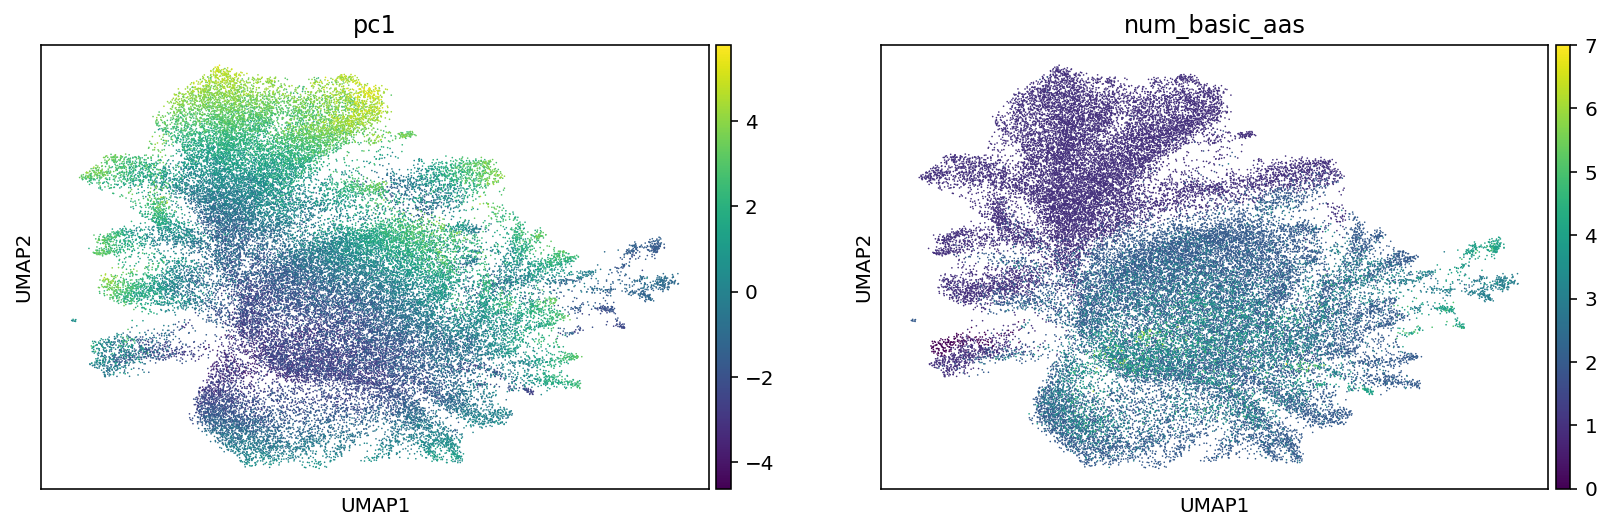

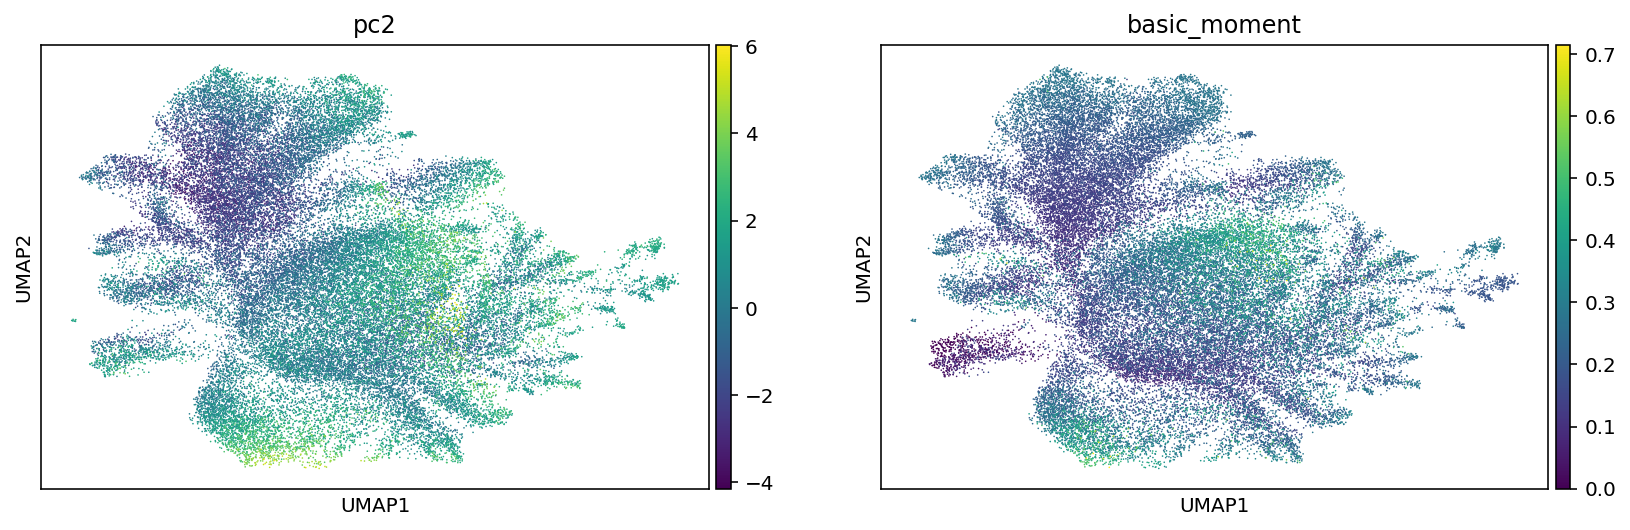

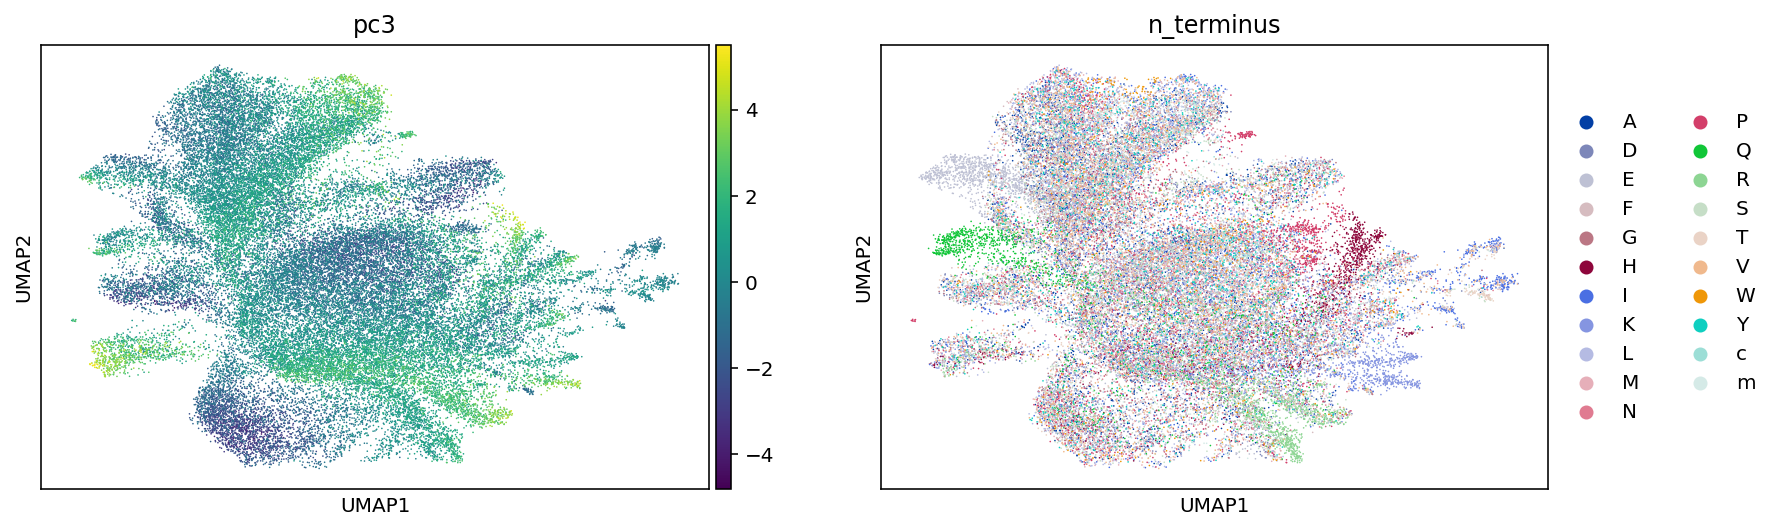

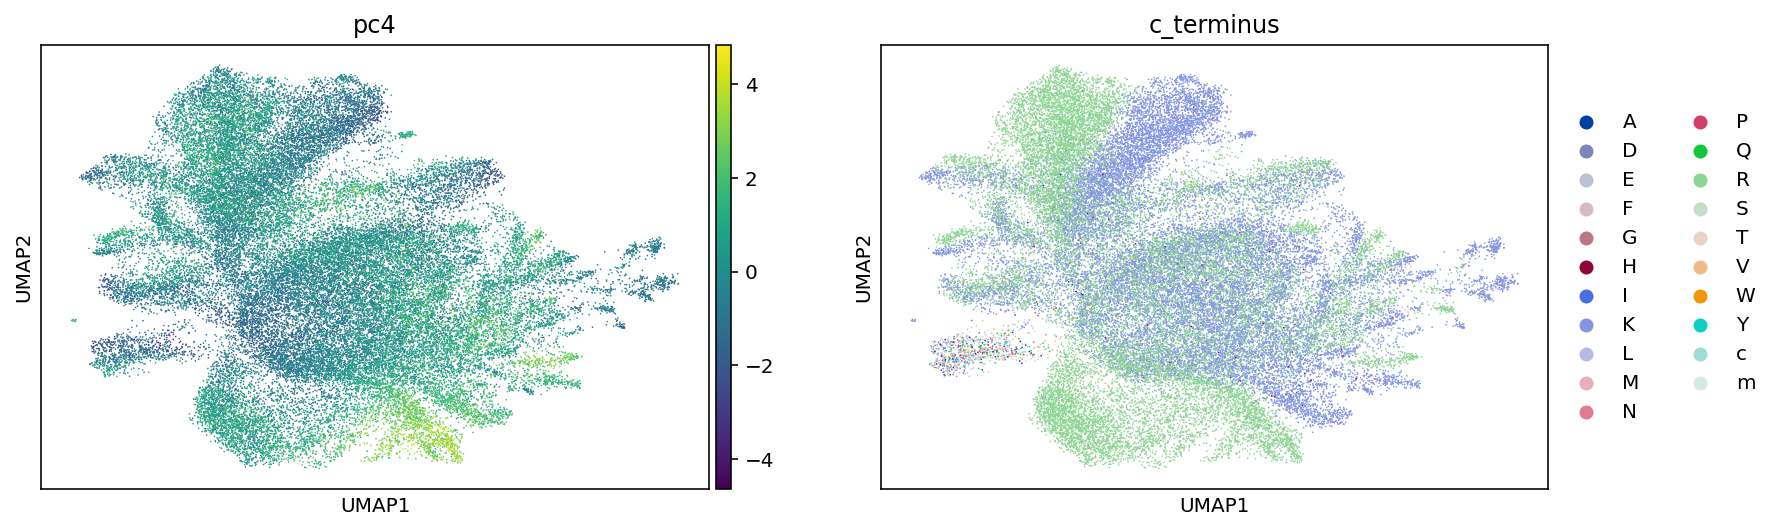

In [15]:
def proton_moment(sequence):
    is_basic = np.array([aa in 'RHK' for aa in sequence])
    return (is_basic * np.arange(len(sequence))).sum() / np.arange(len(sequence)).sum()

import scanpy as sc

adata = sc.AnnData(embeddings)

sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

adata.obs['sequence'] = adata.obs.index
adata.obs['length'] = adata.obs['sequence'].map(len)
adata.obs['n_terminus'] = adata.obs['sequence'].str[0]
adata.obs['c_terminus'] = adata.obs['sequence'].str[-1]
adata.obs['num_basic_aas'] = adata.obs['sequence'].map(lambda s: sum([aa in 'RHK' for aa in s]))
adata.obs['basic_moment'] = adata.obs['sequence'].map(proton_moment)

adata.obs['pc1'] = adata.obsm['X_pca'][:,0]
adata.obs['pc2'] = adata.obsm['X_pca'][:,1]
adata.obs['pc3'] = adata.obsm['X_pca'][:,2]
adata.obs['pc4'] = adata.obsm['X_pca'][:,3]

sc.pl.umap(adata,color=['pc1','num_basic_aas'])
sc.pl.umap(adata,color=['pc2','basic_moment'])
sc.pl.umap(adata,color=['pc3','n_terminus'])
sc.pl.umap(adata,color=['pc4','c_terminus'])

PC1 is the number of basic amino acids in the sequence. My guess is this relates to a hard constraint the model must learn: fragments cannot have a greater charge than the peptide.

<AxesSubplot:xlabel='num_basic_aas', ylabel='pc1'>

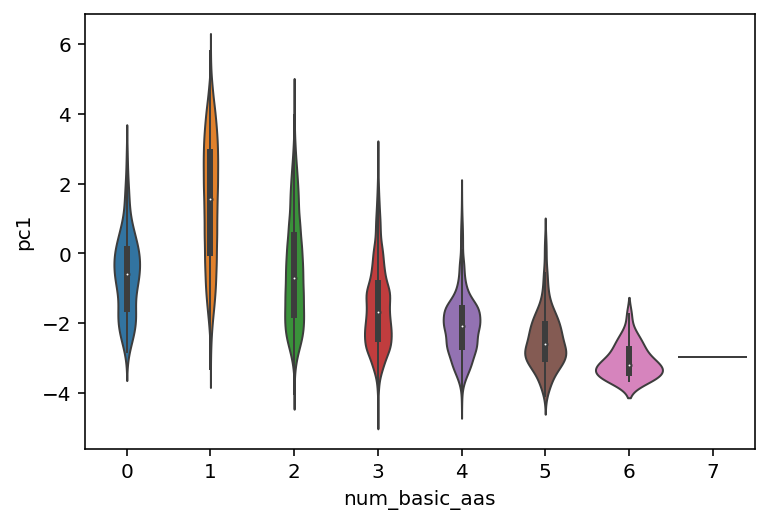

In [16]:
sns.violinplot(data=adata.obs,x='num_basic_aas',y='pc1',linewidth=1)

PC2 is "the first moment of the charge distribution, assuming protons localize only at basic AAs (R/K/H) with equal probability".

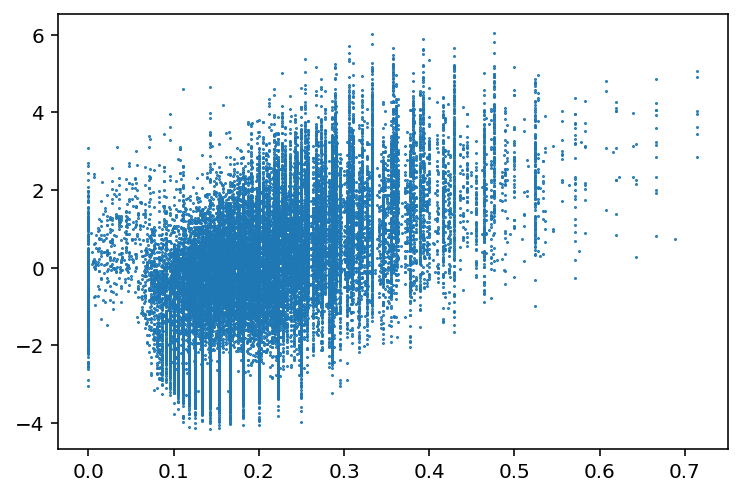

In [17]:
plt.plot(adata.obs['basic_moment'],adata.obs['pc2'],'.',markersize=1)

PC3 corresponds to the identity of the N-terminal AA. The ordering roughly corresponds to basicity of the residue, which would recapitulate known chemistry. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2813199/)

<AxesSubplot:xlabel='n_terminus', ylabel='pc3'>

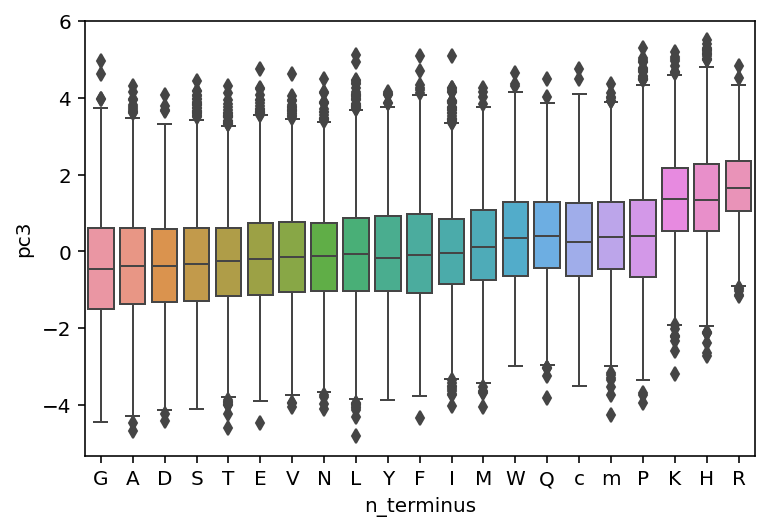

In [18]:
sns.boxplot(data=adata.obs,x='n_terminus',y='pc3',linewidth=1,
     order=adata.obs.groupby('n_terminus')['pc3'].mean().sort_values().index)

PC4 is the identity of the C-terminal AA. As these are tryptic peptides, this is (almost) always R or K; I scale the widths to make this obvious.

(I now notice this effect is less apparent; with simpler models the separation is more pronounced.)

<AxesSubplot:xlabel='c_terminus', ylabel='pc4'>

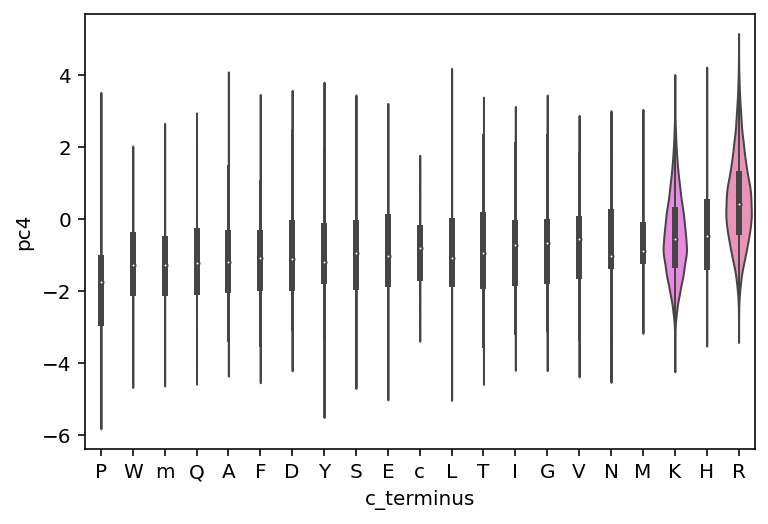

In [19]:
sns.violinplot(data=adata.obs,x='c_terminus',y='pc4',scale='count',linewidth=1,
    order=adata.obs.groupby('c_terminus')['pc4'].mean().sort_values().index)